In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from data_source import YahooFinanceDataSource

data_source = YahooFinanceDataSource()
holdings_df = data_source.read_spy_holdings('holdings-daily-us-en-spy.xlsx')
print(f"Found {len(holdings_df)} constituent stocks in SPY ETF.")
end_date = '2025-01-22'  
start_date = '2025-01-02'  
# replace holdings_df ticker BRK.B with BRK-B and BF.B with BF-B, and '-' with USD
holdings_df['Ticker'] = holdings_df['Ticker'].replace({
    'BRK.B': 'BRK-B',
    'BF.B': 'BF-B',
    '-': 'USD'
})
tickers = ['SPY'] + holdings_df['Ticker'].tolist()
print(f"Fetching historical data for SPY and {len(tickers)-1} constituents...")


Found 505 constituent stocks in SPY ETF.
Fetching historical data for SPY and 505 constituents...


In [2]:
price_data = data_source.get_historical_data(tickers, start_date, end_date)
if 'SPY' not in price_data.columns:
    print("Error: SPY data not found in the downloaded data.")
spy_data = price_data['SPY'].copy()
valid_columns = list(price_data.columns[price_data.isna().sum() == 0])

if 'SPY' not in valid_columns and 'SPY' in price_data.columns:
    valid_columns.append('SPY')

price_data = price_data[valid_columns]

valid_constituents = [ticker for ticker in valid_columns if ticker != 'SPY']
print(f"Found valid data for {len(valid_constituents)} out of {len(holdings_df)} constituents.")

print("Calculating weighted portfolio from constituents...")
weighted_portfolio = data_source.calculate_weighted_portfolio(holdings_df, price_data)

print("Verifying SPY returns against weighted constituent returns...")
verification_results = data_source.verify_spy_vs_constituents(
    spy_data,  
    weighted_portfolio, 
    threshold=0.01
)

status = "PASSED" if verification_results['within_threshold'] else "FAILED"
print(f"\nVerification {status}")
print(f"Maximum difference: {verification_results['max_difference']*100:.4f}%")
print(f"Mean difference: {verification_results['mean_difference']*100:.4f}%")
print(f"Spearman Coefficient: {verification_results['spearman_coeff']*100:.4f}%")

[*********************100%***********************]  506 of 506 completed

1 Failed download:
['SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-02 -> 2025-01-22) (Yahoo error = "Data doesn\'t exist for startDate = 1735794000, endDate = 1737522000")')


Found valid data for 504 out of 505 constituents.
Calculating weighted portfolio from constituents...
Verifying SPY returns against weighted constituent returns...

Verification PASSED
Maximum difference: 0.1229%
Mean difference: 0.0494%
Spearman Coefficient: 100.0000%


In [3]:
def plot_comparison(spy_returns: pd.Series, portfolio_returns: pd.Series, title: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.plot(spy_returns.index, spy_returns, label='SPY', color='blue')
    ax1.plot(portfolio_returns.index, portfolio_returns, label='Weighted Portfolio', color='orange')
    ax1.set_title(f"{title} - Daily")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Return')
    ax1.legend()
    ax1.grid(True)
    
    cum_spy = (1 + spy_returns).cumprod()
    cum_portfolio = (1 + portfolio_returns).cumprod()
    
    ax2.plot(cum_spy.index, cum_spy, label='SPY', color='blue')
    ax2.plot(cum_portfolio.index, cum_portfolio, label='Weighted Portfolio', color='orange')
    ax2.set_title(f"{title} - Cumulative")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('spy_verification_results.png')
    print("Saved comparison plot to 'spy_verification_results.png'")


Saved comparison plot to 'spy_verification_results.png'


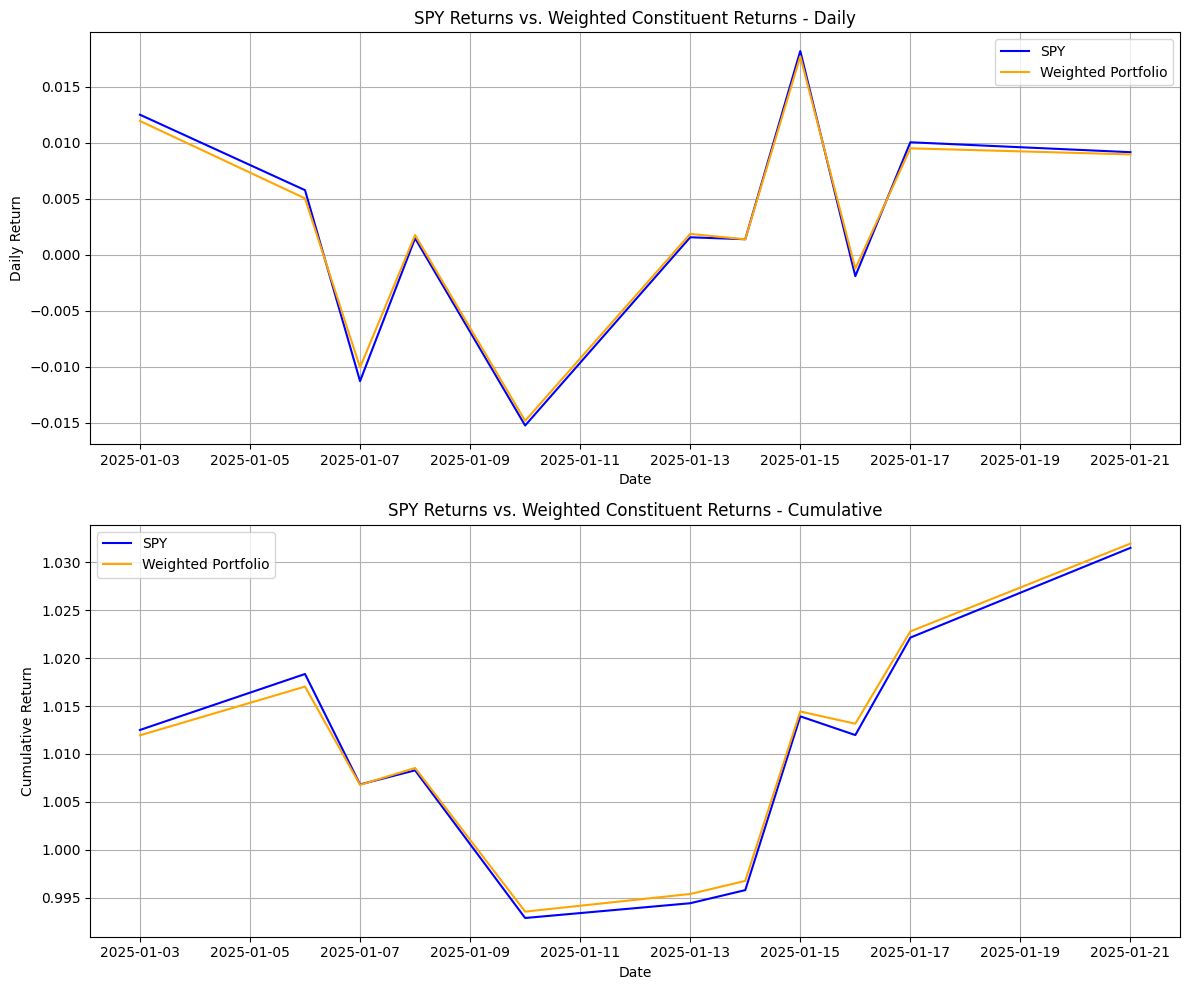

In [4]:
plot_comparison(
    verification_results['spy_returns'], 
    verification_results['portfolio_returns'],
    'SPY Returns vs. Weighted Constituent Returns'
)